# Laugh detector

In [1]:
%%capture

%matplotlib inline

import os
import random
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shutil import copyfile
from scipy.io import wavfile
from keras.models import Model
from IPython.display import SVG
from keras.utils import get_file
from keras.utils import Sequence
from sklearn.metrics import roc_curve, auc
from features.sampler import SSPNetSampler
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Dense, TimeDistributed, concatenate

## Data

In [2]:
SSPNET_FNAME = 'vocalizationcorpus.zip'
SSPNET_NOISY_FNAME = 'vocalizationcorpus_noisy.zip'
SSPNET_URL = f'http://www.dcs.gla.ac.uk/~vincia/datavocalizations/{SSPNET_FNAME}'
SSPNET_NOISY_URL = None
IS_NOISY = True
SSPNET_SAMPLE_PATH = 'sspnet_{}sample.hdf5'.format('noisy_' if IS_NOISY else '')
RENEW_PREPROCESSING = True

In [3]:
def prepare_data(noisy):
    fname, url = (SSPNET_FNAME, SSPNET_URL) if not noisy else (SSPNET_NOISY_FNAME, SSPNET_NOISY_URL)
    data_path = os.path.abspath(os.path.join(get_file(fname, url, extract=True), os.pardir))
    if noisy: 
        prepare_data(False)
        copyfile(f'{data_path}/labels.txt', f'{data_path}/vocalizationcorpus/labels.txt')
    data_path = data_path if not noisy else os.path.join(data_path, 'vocalizationcorpus')
    sample_wav = random.choice(os.listdir(os.path.join(data_path, 'data')))
    sample_wav_path = os.path.join(data_path, f'data/{sample_wav}')
    return data_path, sample_wav_path

In [4]:
%time data_path, sample_wav_path = prepare_data(IS_NOISY)
data_path, sample_wav_path

CPU times: user 17.2 s, sys: 3.95 s, total: 21.1 s
Wall time: 33.1 s


('/home/s_belyaev/.keras/datasets/vocalizationcorpus',
 '/home/s_belyaev/.keras/datasets/vocalizationcorpus/data/S1019.wav')

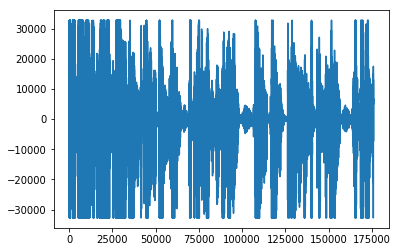

In [5]:
rate, s = wavfile.read(sample_wav_path)
plt.plot(s);
IPython.display.Audio(s, rate=rate)

In [6]:
sampler = SSPNetSampler(data_path)
if os.path.exists(SSPNET_SAMPLE_PATH) and not RENEW_PREPROCESSING:
    print("Loading data...")
    df = pd.read_hdf(SSPNET_SAMPLE_PATH)
else:
    print("Preprocessing data... This takes quite some time.")
    df = sampler.sample()
    df.to_hdf(SSPNET_SAMPLE_PATH, 'df', mode='w', format='t', complevel=9)
df.shape

Preprocessing data... This takes quite some time.


100%|██████████| 2735/2735 [1:17:59<00:00,  1.71s/it]


(287175, 149)

In [7]:
df.head()

mfcc_0      mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
sname frame                                                            
S0337 0     -378.637617  101.881607 -39.029335  63.880909 -49.364409   
      1     -354.759762  116.872446 -49.009303  74.416970 -50.528133   
      2     -300.892596  100.544562 -67.483337  73.742608 -42.389867   
      3     -244.837058   72.696558 -64.809294  72.725897 -36.851980   
      4     -223.430044   78.080366 -89.088471  84.209034 -52.055507   

                mfcc_5     mfcc_6     mfcc_7     mfcc_8    mfcc_9  ...    \
sname frame                                                        ...     
S0337 0      42.554403 -32.233432  19.568675  -7.281890  3.371900  ...     
      1      49.892622 -45.175035  14.504420 -12.584560  2.887958  ...     
      2      32.401588 -32.634292  15.405587  -4.713021  1.640392  ...     
      3      17.751884 -32.190615  14.338877   2.279964  0.592177  ...     
      4      26.627376 -38.652133  19.307701  -1.151586  3.931199  ...     

             fbank_119  fbank_120  fbank_121  fbank_122  fbank_123  fbank_124  \
sname frame                                                                     
S0337 0     -19.400919 -19.623819 -19.831027 -19.981799 -20.111217 -20.217848   
      1     -20.901346 -21.085420 -21.303068 -21.407214 -21.523057 -21.625981   
      2     -18.510880 -18.856657 -19.152493 -19.126686 -19.164262 -19.509278   
      3     -15.625114 -15.862422 -16.023889 -16.064574 -16.253926 -16.466295   
      4     -17.074848 -17.216828 -17.357420 -17.410371 -17.583561 -17.731587   

             fbank_125  fbank_126  fbank_127  laugh  
sname frame                                          
S0337 0     -20.318990 -20.301971 -20.320630      0  
      1     -21.814033 -21.701495 -21.747534      0  
      2     -19.713726 -19.660148 -19.686796      0  
      3     -16.578088 -16.621545 -16.672411      0  
      4     -17.819589 -17.820757 -17.879419      0  

[5 rows x 149 columns]

In [8]:
N_SNAMES = len(df.index.get_level_values(0).unique())
N_FRAMES = len(df.index.get_level_values(1).unique())
N_MFCC_FEATURES = df.columns.str.contains('mfcc').sum()
N_FBANK_FEATURES = df.columns.str.contains('fbank').sum()

## TT generator

In [9]:
def mi_tt_split(df):
    snames_train, snames_test = train_test_split(df.index.get_level_values(0).unique(), test_size=0.2)
    return df.loc[snames_train.tolist()], df.loc[snames_test.tolist()]


def np_prepare(df):
    n_snames = len(df.index.get_level_values(0).unique())
    X = df.drop('laugh', axis=1).as_matrix().reshape((n_snames, N_FRAMES, N_MFCC_FEATURES + N_FBANK_FEATURES))
    X_mfcc, X_fbank = X[:, :, :N_MFCC_FEATURES], X[:, :, N_MFCC_FEATURES:]
    y = np.expand_dims(df.laugh.as_matrix().reshape((n_snames, N_FRAMES)), 2)
    return {'mfcc_input': X_mfcc, 'fbank_input': X_fbank}, {'mfcc_output': y, 'all_output': y}

In [10]:
df_train, df_test = mi_tt_split(df)
(X_train, y_train), (X_test, y_test) = np_prepare(df_train), np_prepare(df_test)
y_test = y_test['all_output']

## Model

In [11]:
BATCH_SIZE = 64
N_EPOCHS = 5
MODEL_PATH = 'model.hdf5'

In [12]:
# MFCC
mfcc_input = Input(shape=(N_FRAMES, N_MFCC_FEATURES), name='mfcc_input')
mfcc_lstm = LSTM(100, return_sequences=True)(mfcc_input)
mfcc_output = TimeDistributed(Dense(1, activation='sigmoid'), name='mfcc_output')(mfcc_lstm)

# FBANK
fbank_input = Input(shape=(N_FRAMES, N_FBANK_FEATURES), name='fbank_input')
fbank_lstm = LSTM(100, return_sequences=True)(fbank_input)
all_lstm = concatenate([mfcc_lstm, fbank_lstm])
all_output = TimeDistributed(Dense(1, activation='sigmoid'), name='all_output')(all_lstm)

# Model
model = Model(inputs=[mfcc_input, fbank_input], outputs=[mfcc_output, all_output])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'],
              loss_weights=[N_MFCC_FEATURES, N_FBANK_FEATURES + N_MFCC_FEATURES])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc_input (InputLayer)         (None, 105, 20)      0                                            
__________________________________________________________________________________________________
fbank_input (InputLayer)        (None, 105, 128)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 105, 100)     48400       mfcc_input[0][0]                 
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 105, 100)     91600       fbank_input[0][0]                
__________________________________________________________________________________________________
concatenat

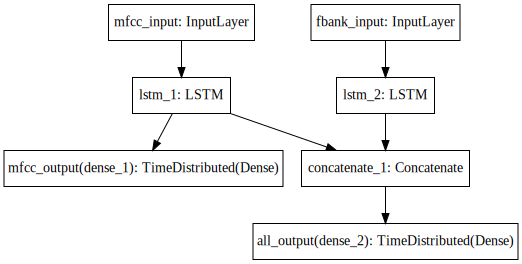

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.1);

Train on 1969 samples, validate on 219 samples
Epoch 1/5
1969/1969 [==============================] - 11s 5ms/step - loss: 27.1855 - mfcc_output_loss: 0.2064 - all_output_loss: 0.1558 - mfcc_output_binary_accuracy: 0.9618 - all_output_binary_accuracy: 0.9447 - val_loss: 28.0470 - val_mfcc_output_loss: 0.1809 - val_all_output_loss: 0.1651 - val_mfcc_output_binary_accuracy: 0.9507 - val_all_output_binary_accuracy: 0.9523
Epoch 2/5
1969/1969 [==============================] - 10s 5ms/step - loss: 20.5885 - mfcc_output_loss: 0.1343 - all_output_loss: 0.1210 - mfcc_output_binary_accuracy: 0.9657 - all_output_binary_accuracy: 0.9669 - val_loss: 25.7059 - val_mfcc_output_loss: 0.1686 - val_all_output_loss: 0.1509 - val_mfcc_output_binary_accuracy: 0.9509 - val_all_output_binary_accuracy: 0.9549
Epoch 3/5
1969/1969 [==============================] - 9s 5ms/step - loss: 19.7682 - mfcc_output_loss: 0.1260 - all_output_loss: 0.1165 - mfcc_output_binary_accuracy: 0.9661 - all_output_binary_accurac

In [15]:
model.save(MODEL_PATH)

## Plots

### `AU`c

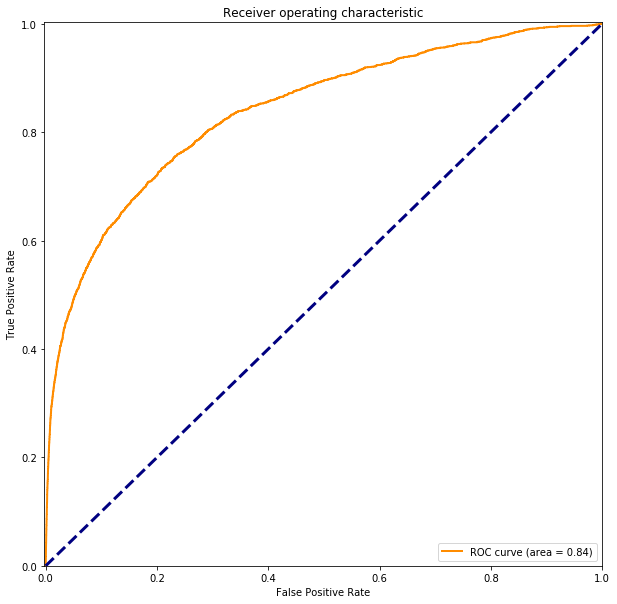

In [16]:
y_pred = model.predict(X_test)[1]

fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.003])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

### Couple of samples

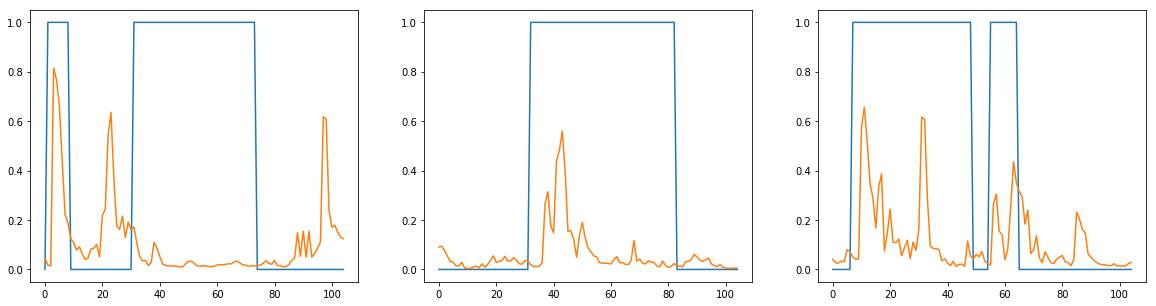

In [17]:
y_pred = model.predict(X_test)[1]
plt.figure(figsize=(20, 5))
for i, i_sname in enumerate(np.argsort(y_test[:, :, -1].mean(axis=1))[-3:]):
    plt.subplot(131 + i)
    plt.plot(np.arange(N_FRAMES), y_test[i_sname, :, -1], y_pred[i_sname, :, -1])

## Predictor

In [18]:
def predict(wav_path):
    sname, df = sampler.cook(wav_path)
    df.index = pd.MultiIndex.from_product([[sname], df.index], names=['sname', 'frame'])
    X, _ = np_prepare(df)
    y_pred = np.squeeze(model.predict(X)[1])
    mask = y_pred >= 0.5
    y_pred[mask], y_pred[np.invert(mask)] = 1, 0
    y_pred = y_pred.astype(int).tolist()
    return sampler.predicted_to_intervals(y_pred)

In [19]:
predict(sample_wav_path)

[]